# Imbalanced Classes Techniques

- **Purpose:** Create models when having imbalanced classes
- **Data:** Habermans Survival Dataset. For more info follow <a href="http://archive.ics.uci.edu/ml/datasets/haberman's+survival" target="_blank">this link</a> 
- **Author:** Emily Diaz
- **Date:** October 13th of 2020 

Useful links (used as reference for this notebook: 
    - https://towardsdatascience.com/fighting-imbalance-data-set-with-code-examples-f2a3880700a6 
    - https://towardsdatascience.com/guide-to-classification-on-imbalanced-datasets-d6653aa5fa23
    - https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/
    

## What does having imbalanced classes mean? 

When having a classification problem (predict a category/class/group), it can happen that given the nature of the information or just randomness of our data sample, that the number of observations on each category are quite different, having a dominant one(s). 

**What is the problem with this?**

When we have imbalanced classes, our models tend to create a bias toward predicting well one category or just assigned everyone to the most frequent one, because with that split we can get a high accuracy and it doesn't have enough data to find the patterns that differentiate the groups. In conclusion, the classifier models tend to ignore small classes while concentrating on classifying the large ones accurately.

**How to define if we have a imbalanced issue?** 

There is no rule on the frequency percentage for a category to be considered imbalanced, however some cases there is a clear view of imbalance, for example 90% vs 10% categories. A way to detect it is when our models are tending to predict the higher frequency group in most of the cases. 

**Some examples of cases with natural imbalanced classes:** 
- Fraud dectection
- Predictive maintenance (failure vs non failure)
- Medical diagnosis

**There are different ways of fixing the imbalance:**
1. **Sampling:** Adding or removing cases so the overall dataset is more balanced. **Examples:** Undersampling, oversampling, SMOTE
2. **Cost-functions:** over or under sampling by altering the relative weighting of individual samples
   

This notebook is divided into the following sections/steps:
1. [Libraries](#libraries)
2. [Load data](#loaddata)
3. [Data Exploration](#exploration)
4. [Data Preparation](#dataprep)
5. [Analysis](#analysis)
6. [Final model](#finalmodel)
7. [Understanding error measures on classification](#classerror)

<a id="libraries"></a>
# 1. Libraries

In [11]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier # xgboost classifier
from sklearn.preprocessing import MinMaxScaler # scaling data to 0-1 range
from sklearn.model_selection import train_test_split #train/test split
from sklearn.metrics import accuracy_score # to score models
from sklearn.metrics import classification_report # classification report
from sklearn.metrics import plot_confusion_matrix # confusion matrix
from imblearn.under_sampling import RandomUnderSampler # random undersampling
import collections # for counter function
from imblearn.over_sampling import SMOTE # SMOTE technique
from imblearn.under_sampling import NearMiss # NearMiss technique
from sklearn.metrics import roc_auc_score # ROC score for model
from sklearn.metrics import f1_score # F1 Score for model
from sklearn.svm import SVC # SVM with cost-learning 
from sklearn.metrics import roc_curve # ROC curve
import matplotlib.pyplot as plt # plot
import shap # shap values for interpretation

/Users/natashadiaz/opt/anaconda3/envs/ml_models/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Function 
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

<a id="loaddata"></a>
# 2. Load Data

In [6]:
df = pd.read_csv('./1_Input/haberman.data', header=0, names=['Age of Patient', 'Year of Operation', 'Positive Axillary Nodes', 'Survival Status'])
print(df.shape)
df.head()


(305, 4)


,Age of Patient,Year of Operation,Positive Axillary Nodes,Survival Status
0,30,62,3,1
1,30,65,0,1
2,31,59,2,1
3,31,65,4,1
4,33,58,10,1


<a id="exploration"></a>
# 3. Exploration

In [12]:
df.describe()

,Age of Patient,Year of Operation,Positive Axillary Nodes,Survival Status
count,305.000000,305.000000,305.000000,305.000000
mean,52.531148,62.849180,4.036066,1.265574
std,10.744024,3.254078,7.199370,0.442364
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,61.000000,66.000000,4.000000,2.000000
max,83.000000,69.000000,52.000000,2.000000


<a id="dataprep"></a>
# 4. Data Preparation

Split into X and Y

In [6]:
X = df.drop(columns= ['Survival Status'])
y = df['Survival Status']

Scale data

In [7]:
# Initialize min/max scaler: this takes data to a 0 to 1 scale
scaler = MinMaxScaler()

In [8]:
scaled_X = scaler.fit_transform(X)

Test/train

In [9]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

<a id="analysis"></a>
# 5. Analysis

Model without any modification

In [10]:
xgb_model = XGBClassifier().fit(X_train, y_train)

# predict
xgb_y_predict = xgb_model.predict(X_test)

# accuracy score
xgb_score = accuracy_score(xgb_y_predict, y_test)

print('Accuracy score is:', xgb_score)

Accuracy score is: 0.7704918032786885


Let's check other metrics

In [11]:
print(classification_report(y_test, xgb_y_predict))

              precision    recall  f1-score   support

           1       0.84      0.87      0.85        47
           2       0.50      0.43      0.46        14

    accuracy                           0.77        61
   macro avg       0.67      0.65      0.66        61
weighted avg       0.76      0.77      0.76        61



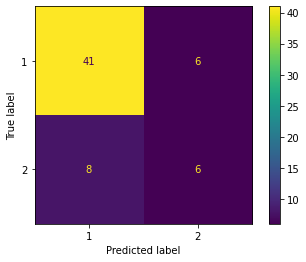

In [12]:
plot_confusion_matrix(xgb_model, X_test, y_test)

We can see that the model is predicting mostly category 1:the patient survived 5 years or longer, since is the biggest group. 

Let's apply techniques to fix imbalanced classes

## 5.1 Under/over sampling

<img src="img/undersampling.png" />

In [13]:
# Random Under Sampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print('original dataset shape:', collections.Counter(y_train))
print('Resample dataset shape', collections.Counter(y_rus))

original dataset shape: Counter({1: 177, 2: 67})
Resample dataset shape Counter({1: 67, 2: 67})


In [14]:
# New model with undersampling
xgb_model = XGBClassifier().fit(X_rus, y_rus)
# predict
xgb_y_predict = xgb_model.predict(X_test)
# accuracy score
xgb_score = accuracy_score(xgb_y_predict, y_test)

print('Accuracy score is:', xgb_score)

Accuracy score is: 0.5081967213114754


In [15]:
print(classification_report(y_test, xgb_y_predict))

              precision    recall  f1-score   support

           1       0.84      0.45      0.58        47
           2       0.28      0.71      0.40        14

    accuracy                           0.51        61
   macro avg       0.56      0.58      0.49        61
weighted avg       0.71      0.51      0.54        61



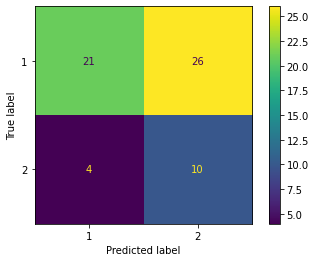

In [16]:
plot_confusion_matrix(xgb_model, X_test, y_test)

## 5.2 SMOTE

<img src="img/smote.png" />

**SMOTE (Synthetic minority oversampling technique):**

Generates new samples in between existing data points based on their local density and their borders with the other class. Not only does it perform oversampling, but can subsequently use cleaning techniques (undersampling) to remove redundancy in the end.

The algorithm for SMOTE is as follows. For each minority sample:
- Find its k-nearest minority neighbours
- Randomly select j of these neighbours
- Randomly generate synthetic samples along the lines joining the minority sample and its j selected neighbours (j depends on the amount of oversampling desired)


In [17]:
smote = SMOTE()

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', collections.Counter(y_train))
print('Resample dataset shape', collections.Counter(y_smote))


Original dataset shape Counter({1: 177, 2: 67})
Resample dataset shape Counter({1: 177, 2: 177})


In [18]:
# New model with undersampling
xgb_model = XGBClassifier().fit(X_smote, y_smote)
# predict
xgb_y_predict = xgb_model.predict(X_test)
# accuracy score
xgb_score = accuracy_score(xgb_y_predict, y_test)

print('Accuracy score is:', xgb_score)

Accuracy score is: 0.7377049180327869


In [19]:
print(classification_report(y_test, xgb_y_predict))

              precision    recall  f1-score   support

           1       0.84      0.81      0.83        47
           2       0.44      0.50      0.47        14

    accuracy                           0.74        61
   macro avg       0.64      0.65      0.65        61
weighted avg       0.75      0.74      0.74        61



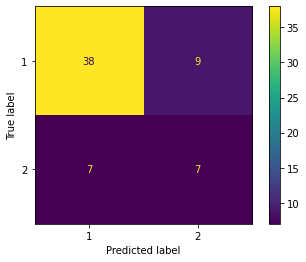

In [20]:
plot_confusion_matrix(xgb_model, X_test, y_test)

## 5.3 NearMiss

NearMiss is an under-sampling technique. Instead of resampling the Minority class, using a distance, this will make the majority class equal to the minority class.

In [21]:
nm = NearMiss()

X_nm, y_nm = nm.fit_resample(X_train, y_train)

print('Original dataset shape:', collections.Counter(y_train))
print('Resample dataset shape:', collections.Counter(y_nm))

Original dataset shape: Counter({1: 177, 2: 67})
Resample dataset shape: Counter({1: 67, 2: 67})


In [22]:
# New model with undersampling
xgb_model = XGBClassifier().fit(X_nm, y_nm)
# predict
xgb_y_predict = xgb_model.predict(X_test)
# accuracy score
xgb_score = accuracy_score(xgb_y_predict, y_test)

print('Accuracy score is:', xgb_score)

Accuracy score is: 0.6065573770491803


In [23]:
print(classification_report(y_test, xgb_y_predict))

              precision    recall  f1-score   support

           1       0.90      0.55      0.68        47
           2       0.34      0.79      0.48        14

    accuracy                           0.61        61
   macro avg       0.62      0.67      0.58        61
weighted avg       0.77      0.61      0.64        61



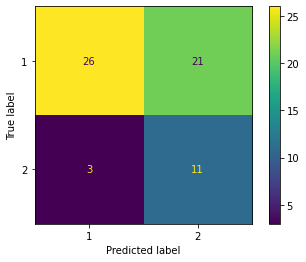

In [24]:
plot_confusion_matrix(xgb_model, X_test, y_test)

## 5.4 Cost-sensitive algorithm

We can also change the algorithm to a penalized learning one that increase the cost of classification mistakes on the minority class.

A popular algorithm for this technique is Penalized-SVM.During training, we can use the argument class_weight=’balanced’ to penalize mistakes on the minority class by an amount proportional to how under-represented it is.We also want to include the argument probability=True if we want to enable probability estimates for SVM algorithms.

[source](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

In [25]:
# we can add class_weight='balanced' to add panalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(X_train, y_train)

svc_predict = svc_model.predict(X_test)# check performance
print('ROCAUC score:',roc_auc_score(y_test, svc_predict))
print('Accuracy score:',accuracy_score(y_test, svc_predict))
print('F1 score:',f1_score(y_test, svc_predict))


ROCAUC score: 0.5972644376899696
Accuracy score: 0.6885245901639344
F1 score: 0.7912087912087913


In [26]:
print(classification_report(y_test, svc_predict))

              precision    recall  f1-score   support

           1       0.82      0.77      0.79        47
           2       0.35      0.43      0.39        14

    accuracy                           0.69        61
   macro avg       0.59      0.60      0.59        61
weighted avg       0.71      0.69      0.70        61



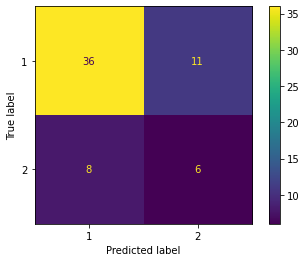

In [27]:
plot_confusion_matrix(svc_model, X_test, y_test)

### Conclusion

- There are several methods, **we must try several** when in front of imbalanced classes as the best one depends on data. 
- **The best method will also depend on what we are trying to optimize** (a misclassification oncategory 1 or 2 have higher impact?)
- **There are other methods** and variations of these ones to try (not necessarily create 50/50, try random oversampling or others)
- For this case, we might want to stick with the **NearMiss** method if the goal is to have similar accuracies per category

<a id="finalmodel"></a>
# 6. Final model 

In [28]:
# Final model
xgb_model = XGBClassifier().fit(X_nm, y_nm)
# predict
xgb_y_predict = xgb_model.predict(X_test)
# accuracy score
xgb_score = accuracy_score(xgb_y_predict, y_test)
print('Accuracy score is:', xgb_score)

Accuracy score is: 0.6065573770491803


### Variable importance

In [29]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
Positive Axillary Nodes,0.624176
Age of Patient,0.203746
Year of Operation,0.172078


<AxesSubplot:xlabel='Feature'>

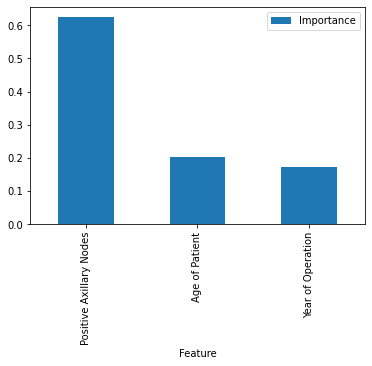

In [30]:
importances.plot.bar()

### Shap values
The SHAP values for XGBoost explain the margin output of the model, since it's a black box and the relationship is not linear, this is a model that runs on top of XGB to be able to explain the impact on each observation of each feature

Helpful links:
- https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27 

In [31]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(scaled_X)

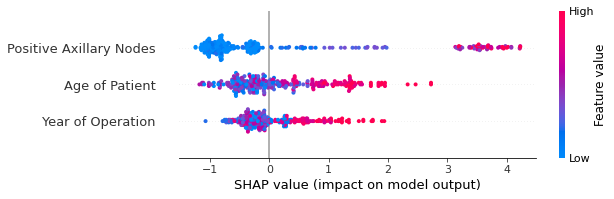

In [32]:
shap.summary_plot(shap_values, scaled_X, feature_names = X.columns)

Every observation has one dot on each row/y axis. The x position of the dot is the impact of that feature on the model’s prediction for the observation, and the color of the dot represents the value of that feature for that observation. Since the XGBoost model has a logistic loss the x-axis has units of log-odds (Tree SHAP explains the change in the margin output of the model). The y position is sorted by variable importance in descending order.

We can interpret that **Positive Axillary Nodes is the variable with higher impact**. Additional, when the value is low (blue points) they have a negative impact in probability (likely to be low category, in this case 1: *"The patient survived 5 years or longer"* and when value is high, it increases the probability to be *"the patient died within 5 year"*

<a id="classerror"></a>
## 7. Understanding measures of error on classification models - binary 

**Important concepts:** 
- TP = True Positive – The model predicted the positive class correctly, to be a positive class.
- FP = False Positive – The model predicted the negative class incorrectly, to be a positive class.
- FN = False Negative – The model predicted the positive class incorrectly, to be the negative class.
- TN = True Negative – The model predicted the negative class correctly, to be the negative class.

**Type of errors:**
- Type 1 Error: The model predicted the instance to be a Positive class, but it is incorrect. This is False Positive (FP).
- Type 2 Error: The model predicted the instance to be the Negative class, but is it incorrect. This is False Negative (FN).

### Confusion matrix - explained

**Formulas**

$Recall = TP / (TP + FN)$
<br>
$Precision = TP / (TP + FP)$
<br>
$F-Score = (2 * Recall * Precision) / (Recall + Precision)$


#### With our data:

In [33]:
print(classification_report(y_test, xgb_y_predict))

              precision    recall  f1-score   support

           1       0.90      0.55      0.68        47
           2       0.34      0.79      0.48        14

    accuracy                           0.61        61
   macro avg       0.62      0.67      0.58        61
weighted avg       0.77      0.61      0.64        61



In [34]:
# Precision examples (with confusion matrix values below):
print(26/(26+3))
print(11/(11+21))

0.896551724137931
0.34375


In [35]:
# Recall examples (with confusion matrix values below):
print(26/(26+21))
print(11/(11+3))

0.5531914893617021
0.7857142857142857


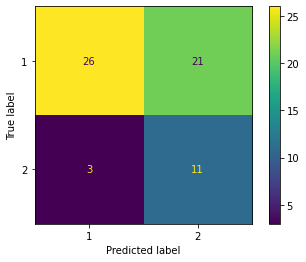

In [36]:
plot_confusion_matrix(xgb_model, X_test, y_test)

### ROC curves - explained

An ROC curve is a two-dimensional graph to depicts trade-offs between benefits (true positives) and costs (false positives). It displays a relation between sensitivity and specificity for a given classifier (binary problems, parameterized classifier or a score classification).

<img src="img/roc.png" />

AUC–ROC curve is the model selection metric for bi–multi class classification problem. ROC is a probability curve for different classes. ROC tells us how good the model is for distinguishing the given classes, in terms of the predicted probability.A typical ROC curve has False Positive Rate (FPR) on the X-axis and True Positive Rate (TPR) on the Y-axis.

The area covered by the curve is the area between the orange line (ROC) and the axis. This area covered is AUC. The bigger the area covered, the better the machine learning models is at distinguishing the given classes. Ideal value for AUC is 1.

Reference links:

- https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

- https://stackabuse.com/understanding-roc-curves-with-python/

#### With our data: 

AUC: 0.68


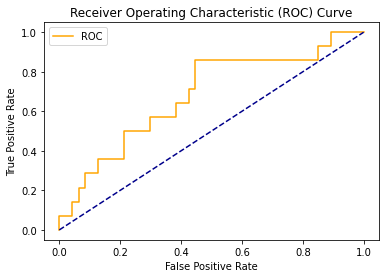

In [37]:
# Obtain probabilities
probs = xgb_model.predict_proba(X_test)
probs = probs[:, 1]


auc = roc_auc_score((y_test)-1, probs)
print('AUC: %.2f' % auc)

# Get ROC curve
fpr, tpr, thresholds = roc_curve((y_test)-1, probs)
plot_roc_curve(fpr, tpr)

Note: There are other efficient ways with decision tree based techniques to apply the weighting inside the model